In [1]:
import numpy as np
import xarray as xr
import os
import sys
sys.path.append("../")
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from src.data_utils import *        
from src.models import DeepONet
from src.pinn_train_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = "../data/"

time_start = "2017-01-01"
time_end = "2022-12-31"

zarr_ds = load_data(data_dir, time_start=time_start, time_end=time_end)

In [3]:
batch_size = 100
train_loader, test_loader = get_data_loaders(zarr_ds, 0.8, batch_size=batch_size)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def get_water_mask(zarr_ds):
    st_ = zarr_ds["sst"].values[0, :, :]
    water_mask = np.zeros_like(st_)
    water_mask[np.isnan(st_)] = 1.0
    return torch.tensor(water_mask)

In [6]:
water_mask = get_water_mask(zarr_ds)

In [8]:
model = DeepONet(9, 2, 64, 100, (176, 240)).to(device)
opt = torch.optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.MSELoss()
scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=10, verbose=True)
lambda_phys = 0.25
D = 1e-4

In [22]:
torch.random.manual_seed(0)

In [9]:
torch.cuda.empty_cache()
num_sensors = 1000
n_epochs = 100
train_losses, test_losses = train(
    model,
    opt,
    criterion,
    train_loader,
    test_loader,
    device,
    water_mask,
    sample_water_only=True,
    num_epochs=n_epochs,
    lambda_physics=lambda_phys,
    scheduler=scheduler,
    num_sensors=num_sensors,
    show_every=10,
)

Training epoch 1:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/100, Train Loss: 0.0056, Val Loss: 0.0060, Val phys. Loss: 0.0015


Epoch 20/100, Train Loss: 0.0052, Val Loss: 0.0056, Val phys. Loss: 0.0014


Epoch 30/100, Train Loss: 0.0049, Val Loss: 0.0053, Val phys. Loss: 0.0017


Epoch 40/100, Train Loss: 0.0047, Val Loss: 0.0051, Val phys. Loss: 0.0017


Epoch 50/100, Train Loss: 0.0046, Val Loss: 0.0052, Val phys. Loss: 0.0018


Epoch 60/100, Train Loss: 0.0045, Val Loss: 0.0050, Val phys. Loss: 0.0019


Epoch 70/100, Train Loss: 0.0044, Val Loss: 0.0050, Val phys. Loss: 0.0019


Epoch 00073: reducing learning rate of group 0 to 1.0000e-04.


Epoch 80/100, Train Loss: 0.0044, Val Loss: 0.0049, Val phys. Loss: 0.0019


Epoch 00088: reducing learning rate of group 0 to 5.0000e-05.


Epoch 90/100, Train Loss: 0.0044, Val Loss: 0.0049, Val phys. Loss: 0.0019


Epoch 100/100, Train Loss: 0.0044, Val Loss: 0.0049, Val phys. Loss: 0.0020


In [10]:
def sample_grid(model, x):
    torch.cuda.empty_cache()
    batch_size = x.shape[0]
    height, width = (176, 240)
    dev = x.device
    grid_coords = get_grid_coords(batch_size, height, width).to(dev)

    output = torch.zeros((batch_size, height, width)).to(dev)
    chunk_size = 2000  # Adjust based on your GPU memory
    for i in range(0, height * width, chunk_size):
        chunk_coords = grid_coords[:, i : i + chunk_size, :]
        with torch.no_grad():
            chunk_output = model(x, chunk_coords)
        output.view(batch_size, -1)[:, i : i + chunk_size] = chunk_output
    torch.cuda.empty_cache()
    return output.cpu().numpy()

In [11]:
x, y = next(iter(train_loader))
x = x.to(device)
output = sample_grid(model, x)

In [26]:
def plot_grid_output(
    model, x, y, water_mask, batch_ind=2, savefig=False, savename=None
):
    wm = (1.0 - water_mask).repeat(batch_size, 1, 1)
    output = sample_grid(model, x)
    masked_output = wm * output
    fig, axs = plt.subplots(1, 3, figsize=(12, 10))
    axs[0].imshow(y.cpu()[batch_ind, :, :], clim=(0, 1))
    axs[0].set_title("Original image")
    axs[1].imshow(masked_output[batch_ind, :, :], clim=(0, 1))
    axs[1].set_title("Model output sampled at grid (masked)")
    axs[2].imshow(output[batch_ind, :, :], clim=(0, 1))
    axs[2].set_title("Model Output sampled at grid (unnmasked)")

    if savefig:
        plt.savefig(f"../plots/{savename}.png")

    plt.show()

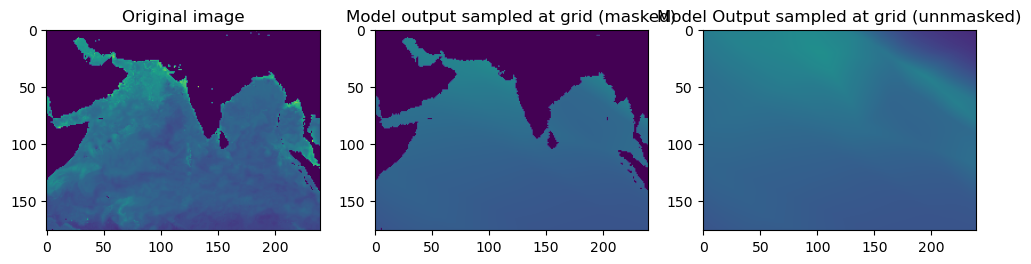

In [28]:
plot_grid_output(
    model, x, y, water_mask, batch_ind=10, savefig=True, savename=f"DONet_v0_D_{D}"
)

TypeError: Figure.savefig() takes 2 positional arguments but 3 were given

<Figure size 640x480 with 0 Axes>

In [ ]:
wm = (1.0 - water_mask).repeat(batch_size, 1, 1)
grid_coords = get_grid_coords(batch_size, 176, 240)
sampled_image = sample_image_at_points(y, grid_coords)
img = sampled_image.reshape(batch_size, 176, 240)

t = 2

fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(y[t, :, :])
axs[0].set_title("Original image")
axs[1].imshow(masked_output[t, :, :], clim=(0, 1))
axs[1].set_title("Model output sampled at grid")